#### Project set up and data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
#load dataset
df_customer = pd.read_csv('/Users/joshuafan/Work/proton_case_study/Take Home - Data Analyst/vpn_customer_data.csv')
df_events = pd.read_csv('/Users/joshuafan/Work/proton_case_study/Take Home - Data Analyst/vpn_events.csv')
df_ef = pd.read_csv('/Users/joshuafan/Work/proton_case_study/Take Home - Data Analyst/vpn_external_factors.csv')

In [4]:
#clean and transform columns for customer dataframe
df_customer['signup_date'] = pd.to_datetime(df_customer['signup_date'])
df_customer['churn_date'] = pd.to_datetime(df_customer['churn_date'], errors='coerce')
df_customer['is_churned'] = df_customer['churn_date'].notna().astype(int)

last_date = df_customer['churn_date'].max() #get max date to calculate how long the user stayed with us
df_customer['tenure_days'] = (df_customer['churn_date'].fillna(last_date) - df_customer['signup_date']).dt.days

df_customer['num_devices'] = df_customer['devices_used'].str.split(',').str.len()
df_customer['num_devices'] = df_customer['num_devices'].fillna(0)

df_customer['num_ticket_types'] = df_customer['support_tickets'].str.split(',').str.len()
df_customer['num_ticket_types'] = df_customer['num_ticket_types'].fillna(0)

# display(df_customer[['signup_date', 'churn_date', 'is_churned', 'tenure_days', 'devices_used', 'num_devices', 'support_tickets', 'num_ticket_types']].head())

In [4]:
#clean and transform columns for events dataframe
df_events['date'] = pd.to_datetime(df_events['date']).dt.date
df_events['date'] = pd.to_datetime(df_events['date'])

# display(df_events.head())

In [5]:
#clean and transform columns for external factor dataframe
df_ef['date'] = pd.to_datetime(df_ef['date'])
df_ef['year_month'] = df_ef['date'].dt.to_period('M')

df_ef['vpn_friendly'] = df_ef['vpn_friendly'].replace('False', '0')
df_ef['vpn_friendly'] = df_ef['vpn_friendly'].astype(float)

df_ef.drop_duplicates(subset=['country', 'year_month'], keep='first', inplace=True)
df_ef = df_ef.drop(columns=['date'])

# display(df_ef.head())

In [6]:
#left join with customer data for analysis 
df_customer['signup_year_month'] = df_customer['signup_date'].dt.to_period('M')
df_merged = pd.merge(
    df_customer,
    df_ef,
    how='left',
    left_on=['signup_year_month', 'signup_country'],
    right_on=['year_month', 'country']
)
# display(df_merged.head())
# df_merged.shape

#### High level analysis to find main churn factor
- Hypothesis: Choosing a monthly or annual plan is a good indicator of churn 
- Finding: Hypothesis supported. Monthly users has a 61% churn rate that is five time more than annual users. => Monthly user is a primary segment of interest

Churn rate by plan type:
      plan  is_churned  churn_rate_percentage
0   annual    0.116720              11.671954
1  monthly    0.616113              61.611308


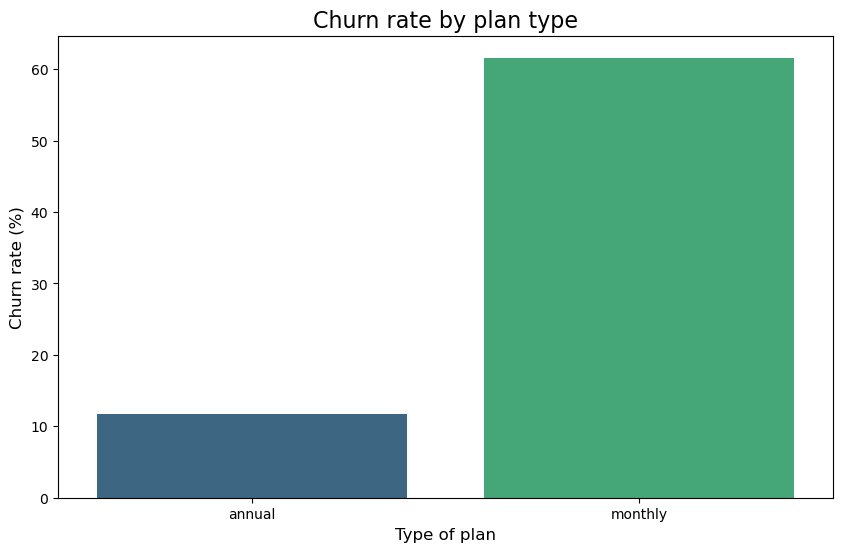

In [7]:
#churn rate of each plan
#dominant churn factor
churn_rate_plan = df_merged.groupby('plan')['is_churned'].mean().reset_index()
churn_rate_plan['churn_rate_percentage'] = churn_rate_plan['is_churned']*100

print(f'Churn rate by plan type:\n{churn_rate_plan}')

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=churn_rate_plan, x='plan', y='churn_rate_percentage', palette='viridis')

ax.set_title('Churn rate by plan type', fontsize=16)
ax.set_xlabel('Type of plan', fontsize=12)
ax.set_ylabel('Churn rate (%)', fontsize=12)

plt.show()

#### Deep dive in the monthly user segment - when 
- Hypothesis: Monthly user churn does not happen randomly
- Finding: 
 - Confirmed. Churn graph is positively skewed, indicating early phase of customer journey is crucial to invest to retain users. 
 - More than half of the churned users do so within the first 4 months. 

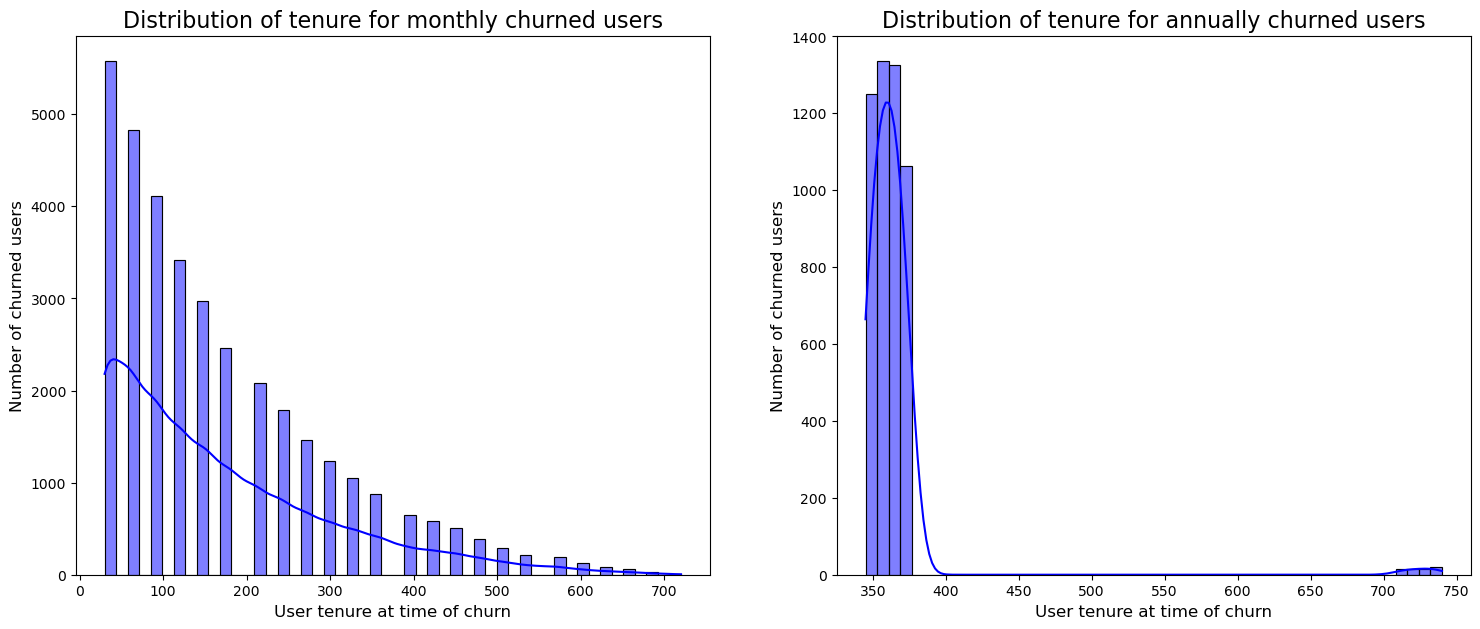

In [10]:
#timing of churning: churn for monthly users is not random but positive skewed 
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

df_monthly_churned = df_merged[(df_merged['plan'] == 'monthly') & (df_merged['is_churned'] == 1)].copy()

sns.histplot(data=df_monthly_churned, x='tenure_days', bins=50, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Distribution of tenure for monthly churned users', fontsize=16)
axes[0].set_xlabel('User tenure at time of churn', fontsize=12)
axes[0].set_ylabel('Number of churned users', fontsize=12)

df_churned_annual = df_merged[(df_merged['is_churned'] == 1) & (df_merged['plan'] == 'annual')]

sns.histplot(data=df_churned_annual, x='tenure_days', bins=50, kde=True, color='blue', ax=axes[1])
axes[1].set_title('Distribution of tenure for annually churned users', fontsize=16)
axes[1].set_xlabel('User tenure at time of churn', fontsize=12)
axes[1].set_ylabel('Number of churned users', fontsize=12)

plt.show()

   days  cumulative_churn_percentage
0    30                    15.924804
1    60                    29.718302
2    90                    41.460488
3   120                    51.237072

51.2% of all monthly subscribers who churn do so within the first 120 days.


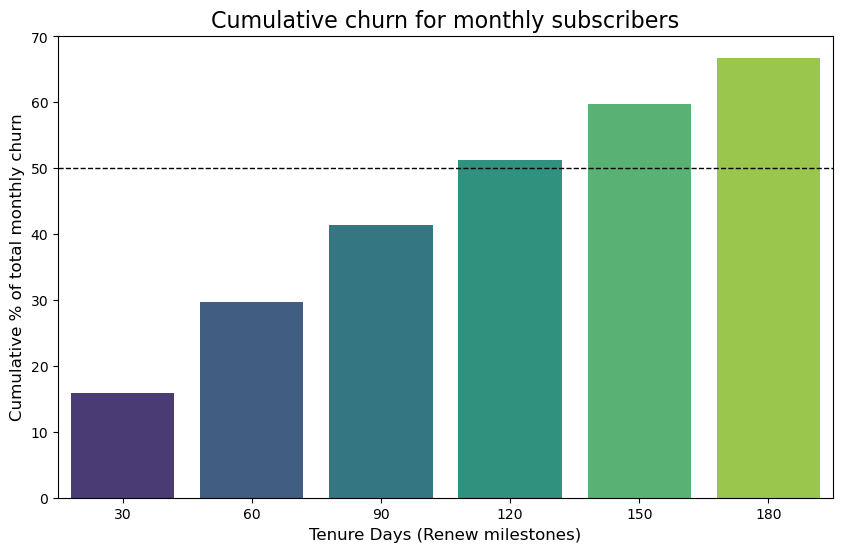

In [11]:
#focus on monthly users
#timing of churning: more than half of all monthly users who churn do so within the first 4 months 
df_monthly_churned = df_merged[(df_merged['plan'] == 'monthly') & (df_merged['is_churned'] == 1)].copy()
total_monthly_churn_users = len(df_monthly_churned)

churn_counts_by_tenure = df_monthly_churned['tenure_days'].value_counts().sort_index()

cumulative_churn = churn_counts_by_tenure.cumsum() #cumulative sum of churned users over time 
cumulative_churn_percentage = (cumulative_churn / total_monthly_churn_users)*100

cumulative_df = pd.DataFrame({'days': cumulative_churn_percentage.index,
                              'cumulative_churn_percentage': cumulative_churn_percentage.values})
print(cumulative_df[cumulative_df['days'] <= 120])

churn_within_120_days = cumulative_df[cumulative_df['days'] == 120]['cumulative_churn_percentage'].iloc[0]
print(f'\n{churn_within_120_days:.1f}% of all monthly subscribers who churn do so within the first 120 days.')

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=cumulative_df[cumulative_df['days'] <= 180], x='days', y='cumulative_churn_percentage', palette='viridis')
ax.set_title('Cumulative churn for monthly subscribers', fontsize=16)
ax.set_xlabel('Tenure Days (Renew milestones)', fontsize=12)
ax.set_ylabel('Cumulative % of total monthly churn', fontsize=12)
ax.axhline(50, color='black', linestyle='--', linewidth=1)

plt.show()

#### Deep dive in the monthly user segment - why 
- Hypothesis: Some factors like low usage, technical/connection issues, device count will be strong indicators 
- Finding: Surprisingly most individual behavioural factors were not strong predictors on their own. Showing the ones I found that are slightly evident in mean difference. 

Monthly subscribers count: 56811

Usage stats for monthly subscribers by churn status:
              count        mean         std   min   25%    50%    75%     max
is_churned                                                                   
0           21809.0  143.153927  101.873602  20.0  89.0  115.0  151.0  1055.0
1           35002.0  131.737186   80.616510  20.0  88.0  112.0  144.0   903.0


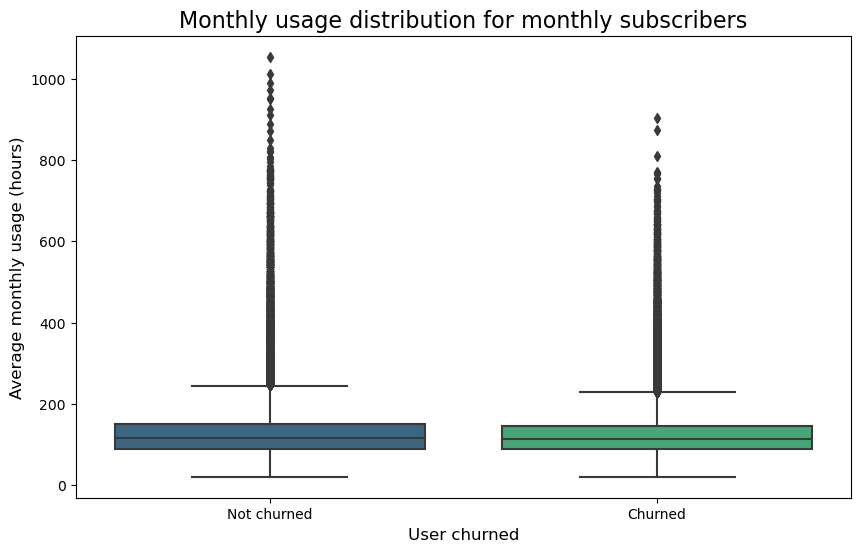

In [12]:
#focus on monthly users 
#behavioural drivers: lower monthly usage have higher churn rate => weak in mean and median 
df_monthly = df_merged[df_merged['plan'] == 'monthly'].copy()

print(f'Monthly subscribers count: {len(df_monthly)}')

print('\nUsage stats for monthly subscribers by churn status:')
print(df_monthly.groupby('is_churned')['monthly_usage_hours'].describe())

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_monthly, x='is_churned', y='monthly_usage_hours', palette='viridis')

ax.set_title('Monthly usage distribution for monthly subscribers', fontsize=16)
ax.set_xlabel('User churned', fontsize=12)
ax.set_ylabel('Average monthly usage (hours)', fontsize=12)
ax.set_xticklabels(['Not churned', 'Churned'])

plt.show()

Contries connected stats for monthly subscribers by churn status:

              count      mean       std  min  25%  50%  75%   max
is_churned                                                       
0           21809.0  5.504654  2.866191  1.0  3.0  6.0  8.0  10.0
1           35002.0  5.476801  2.874734  1.0  3.0  5.0  8.0  10.0


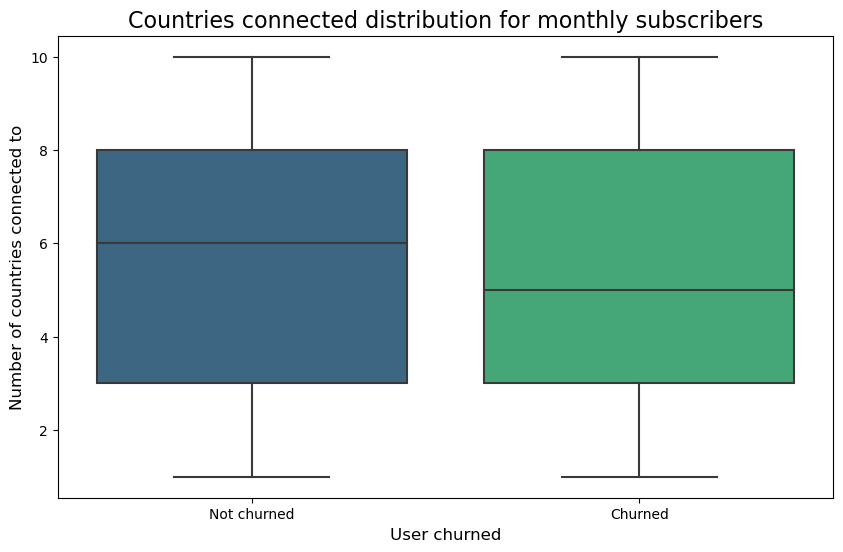

In [13]:
#focus on monthly users 
#behavioural drivers: less countries connected on vpn account have higher churn rate => weak in mean and median 

print('Contries connected stats for monthly subscribers by churn status:\n')
print(df_monthly.groupby('is_churned')['countries_connected_to'].describe())

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_monthly, x='is_churned', y='countries_connected_to', palette='viridis')

ax.set_title('Countries connected distribution for monthly subscribers', fontsize=16)
ax.set_xlabel('User churned', fontsize=12)
ax.set_ylabel('Number of countries connected to', fontsize=12)
ax.set_xticklabels(['Not churned', 'Churned'])

plt.show()

#### Combine drivers of churn - quantifyig the value for their money
- Hypothesis: The cost per hour of usages is a primary driver of churn decision 
- Finding: Strongly supported. With a t test, we found that: 
 - high t value - big difference between means of churn and not churn to the variability within the groups 
 - 0 p value - the difference in means is statistically significant
 - cost per hour of usages is a good indicator for churn decision. 

Cost per hour usage by churn status: 

              count      mean       std       min       25%       50%  \
is_churned                                                              
0           59957.0  0.064767  0.044558  0.005010  0.037803  0.053085   
1           40043.0  0.091234  0.053232  0.007253  0.060545  0.083950   

                 75%     max  
is_churned                    
0           0.081803  0.4995  
1           0.109780  0.4995  


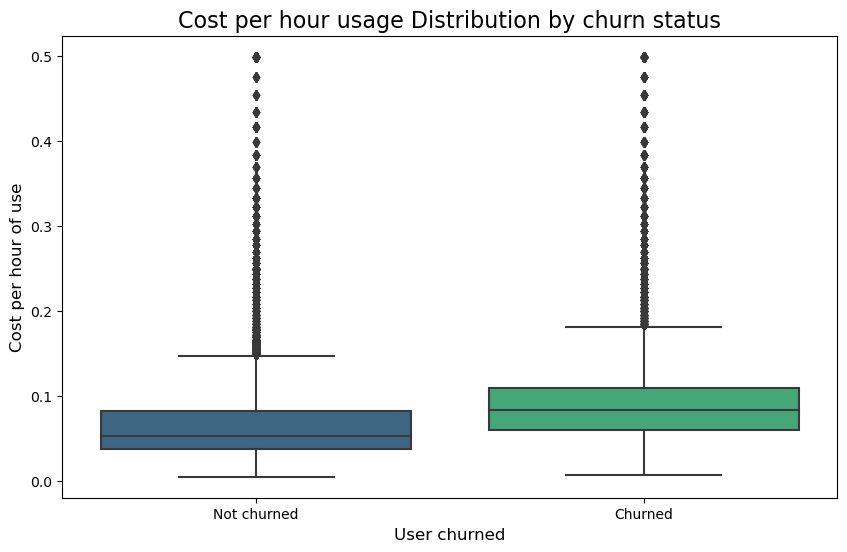

t-statistic: 82.11986985364369
p-value: 0.0


In [14]:
#monthly plan is a dominant factor that the above secondary signals are weak in comparison 
#feature engineer: value for money (cost per average hour usage)
#a higher cost per hour use is more likely to churn 

df_merged['monthly_price'] = np.where(df_merged['plan'] == 'annual', 
                                      df_merged['plan_price'] / 12, 
                                      df_merged['plan_price'])

df_merged['cost_per_hour'] = df_merged['monthly_price'] / df_merged['monthly_usage_hours']

print('Cost per hour usage by churn status: \n')
print(df_merged.groupby('is_churned')['cost_per_hour'].describe())

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_merged, x='is_churned', y='cost_per_hour', palette='viridis')

ax.set_title('Cost per hour usage Distribution by churn status', fontsize=16)
ax.set_xlabel('User churned', fontsize=12)
ax.set_ylabel('Cost per hour of use', fontsize=12)
ax.set_xticklabels(['Not churned', 'Churned'])

plt.show()

#check if mean cost per hour between churn and not churn is statistically significant 
churned_costs = df_merged[df_merged['is_churned'] == 1]['cost_per_hour']
not_churned_costs = df_merged[df_merged['is_churned'] == 0]['cost_per_hour']
t_value, p_value = stats.ttest_ind(churned_costs, not_churned_costs, equal_var=False)
print(f't-statistic: {t_value}')
print(f'p-value: {p_value}')

#### Combining drivers of churn - acquisition source 
- Hypothesis: Real world event that drives a user to sign up will impact their retention 
- Finding: Supported. Political and regulatory events bring lower churn users. 

Churn rate by event type
   event_type  is_churned  churn_rate_percentage
0  employment    0.423967              42.396732
1   political    0.371289              37.128874
2  regulatory    0.332948              33.294798


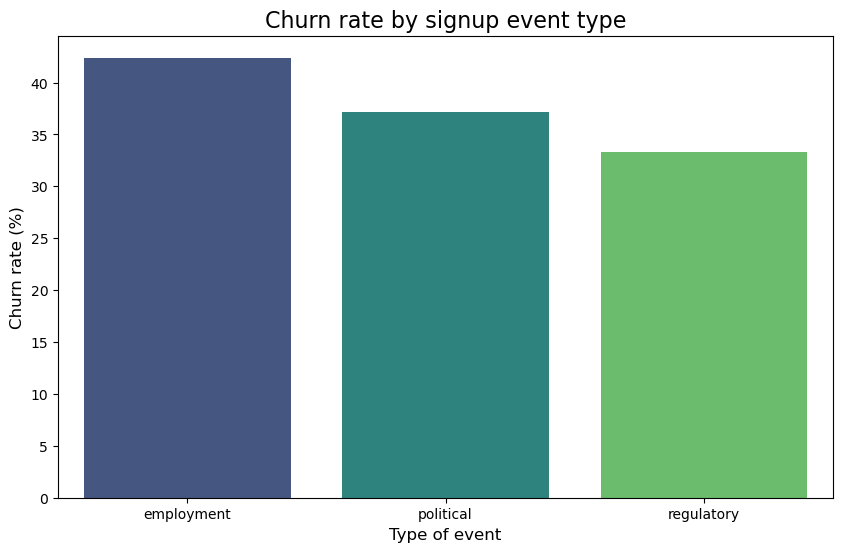

In [15]:
#the impact of acquisition source
#signups for certain events have higher churn rate 
df_events['event_year_month'] = pd.to_datetime(df_events['date']).dt.to_period('M')

df_merged_events = pd.merge(
    df_merged,
    df_events,
    how='left',
    left_on=['signup_year_month', 'country'],
    right_on=['event_year_month', 'country']
)

df_merged_events['is_event_month_signup'] = df_merged_events['event_type'].notna().astype(int)

df_event_users_only = df_merged_events[df_merged_events['is_event_month_signup'] == 1]
churn_by_event_type = df_event_users_only.groupby('event_type')['is_churned'].mean().reset_index().sort_values('is_churned', ascending=False)
churn_by_event_type['churn_rate_percentage'] = churn_by_event_type['is_churned']*100

print('Churn rate by event type')
print(churn_by_event_type)

plt.figure(figsize=(10, 6))

ax = sns.barplot(data=churn_by_event_type, x='event_type', y='churn_rate_percentage', palette='viridis')
ax.set_title('Churn rate by signup event type', fontsize=16)
ax.set_xlabel('Type of event', fontsize=12)
ax.set_ylabel('Churn rate (%)', fontsize=12)

plt.show()

#### Combing drivers of churn - create risk factor


Churn rate by risk score 

   risk_score      mean   size  churn_rate_percentage
0          -1  0.050549    455               5.054945
1           0  0.119619  13217              11.961867
2           1  0.236069  24137              23.606911
3           2  0.400984  23567              40.098443
4           3  0.575119  23962              57.511894
5           4  0.642226  12779              64.222553
6           5  0.683924   1835              68.392371
7           6  1.000000     48             100.000000


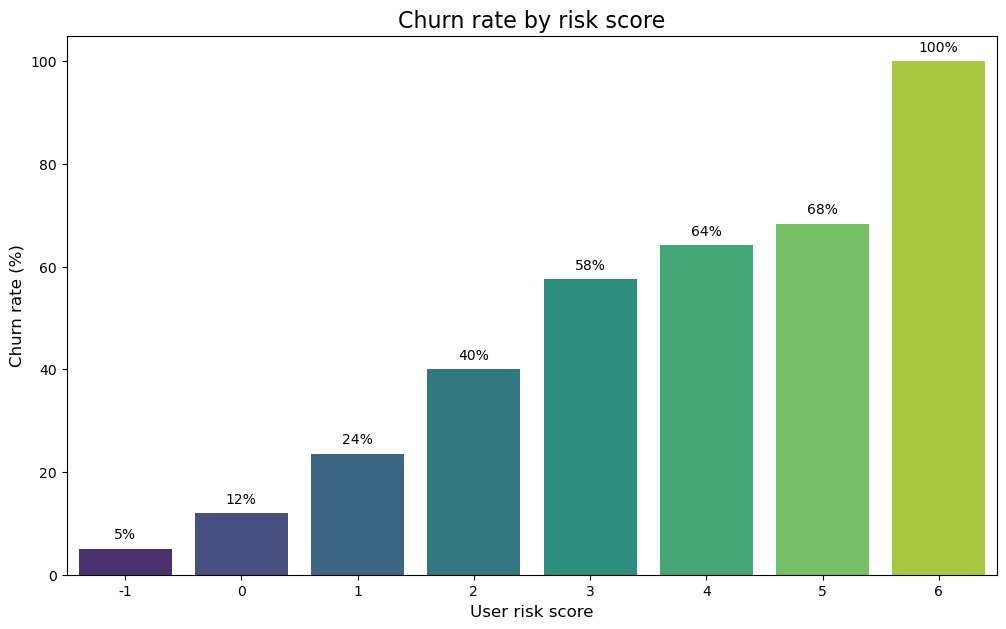

In [16]:
#median of numerical values
median_cost_per_hour = df_merged['cost_per_hour'].median()
median_countries = df_merged['countries_connected_to'].median()
median_usage = df_merged['monthly_usage_hours'].median()


df_merged['risk_score'] = 0

df_merged.loc[(df_merged['plan'] == 'monthly') & (df_merged['tenure_days'] <= 30), 'risk_score'] += 2
df_merged.loc[(df_merged['plan'] == 'monthly') & (df_merged['tenure_days'] > 30), 'risk_score'] += 1

df_merged.loc[df_merged['cost_per_hour'] > median_cost_per_hour, 'risk_score'] += 1
df_merged.loc[df_merged['countries_connected_to'] < median_countries, 'risk_score'] += 1
df_merged.loc[df_merged['monthly_usage_hours'] < median_usage, 'risk_score'] += 1

df_risk_analysis = df_merged_events.copy()
df_risk_analysis['risk_score'] = df_merged['risk_score']
df_risk_analysis.loc[df_risk_analysis['event_type'] == 'employment', 'risk_score'] += 1
df_risk_analysis.loc[df_risk_analysis['event_type'].isin(['political', 'regulatory']), 'risk_score'] -= 1

churn_by_risk = df_risk_analysis.groupby('risk_score')['is_churned'].agg(['mean', 'size']).reset_index()
churn_by_risk['churn_rate_percentage'] = churn_by_risk['mean'] * 100

print('Churn rate by risk score \n')
print(churn_by_risk)

plt.figure(figsize=(12, 7))
ax = sns.barplot(data=churn_by_risk, x='risk_score', y='churn_rate_percentage', palette='viridis')

ax.set_title('Churn rate by risk score', fontsize=16)
ax.set_xlabel('User risk score', fontsize=12)
ax.set_ylabel('Churn rate (%)', fontsize=12)

for p in ax.patches: ax.annotate(f'{p.get_height():.0f}%', 
                (p.get_x() + p.get_width()/2, p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), textcoords='offset points')

plt.show()

### ------------------ Ruled out hypotheses and some other analyses ------------------
Here are some other hypotheses where I tested but did not find clear evidence that it indicates if the user is churned or not. 

Churn rate by number of support tickets: 
   num_tickets  is_churned  churn_rate_percentage
0            0    0.617351              61.735095
1            1    0.613782              61.378250
2            2    0.612963              61.296296
3            3    0.620279              62.027943


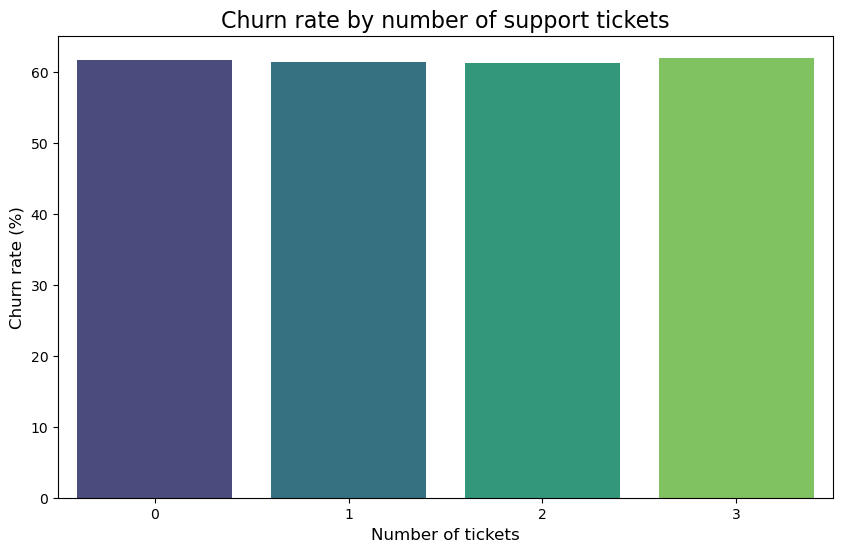

In [17]:
#More tickets do not lead to higher or lower churn
churn_rate_by_tickets = df_monthly.groupby('num_tickets')['is_churned'].mean().reset_index()
churn_rate_by_tickets['churn_rate_percentage'] = churn_rate_by_tickets['is_churned']*100

print("Churn rate by number of support tickets: ")
print(churn_rate_by_tickets)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=churn_rate_by_tickets, x='num_tickets', y='churn_rate_percentage', palette='viridis')

ax.set_title('Churn rate by number of support tickets', fontsize=16)
ax.set_xlabel('Number of tickets', fontsize=12)
ax.set_ylabel('Churn rate (%)', fontsize=12)

plt.show()

Churn rate by specific ticket status: 
   has_xxx_ticket  is_churned  churn_rate_percentage
0               0    0.613504              61.350362
1               1    0.621610              62.160980


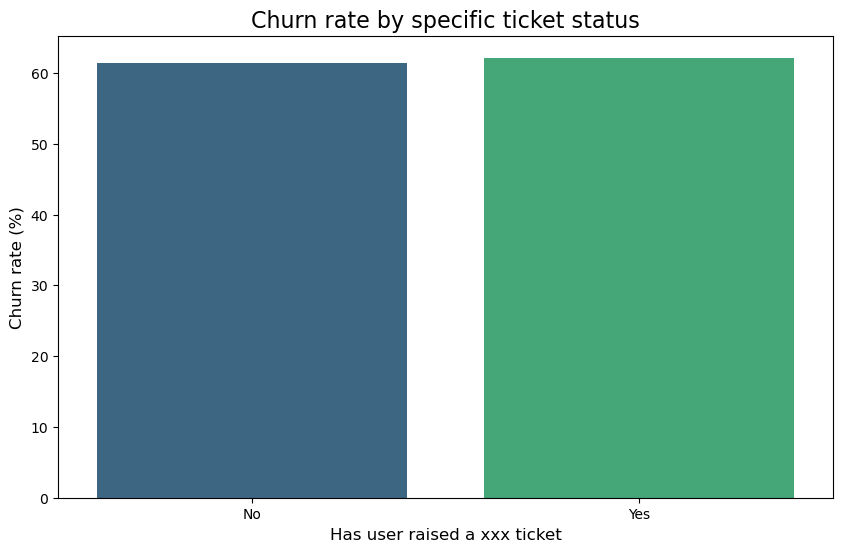

In [18]:
#More tickets do not lead to higher or lower churn
#No specific type of ticket stood out
#techinal, connection, billing, account
df_monthly['has_xxx_ticket'] = df_monthly['support_tickets'].str.contains('technical', na=False).astype(int)

churn_rate_by_specific_ticket = df_monthly.groupby('has_xxx_ticket')['is_churned'].mean().reset_index()
churn_rate_by_specific_ticket['churn_rate_percentage'] = churn_rate_by_specific_ticket['is_churned']*100

print("Churn rate by specific ticket status: ")
print(churn_rate_by_specific_ticket)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=churn_rate_by_specific_ticket, x='has_xxx_ticket', y='churn_rate_percentage', palette='viridis')

ax.set_title('Churn rate by specific ticket status', fontsize=16)
ax.set_xlabel('Has user raised a xxx ticket', fontsize=12)
ax.set_ylabel('Churn rate (%)', fontsize=12)
ax.set_xticklabels(['No', 'Yes'])

plt.show()

Internet freedom index stats for monthly users by churn status: 
              count       mean      std        min   25%   50%   75%   max
is_churned                                                                
0           21809.0  79.392300  6.39837  52.333333  77.0  82.0  84.0  85.0
1           35002.0  79.772784  6.09888  52.333333  77.0  82.0  85.0  85.0


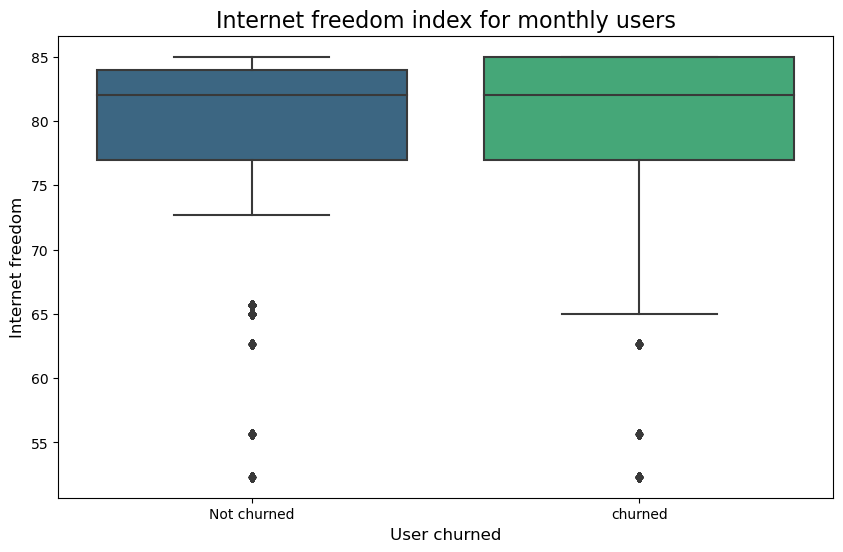

In [19]:
#vpn is a essential need from low freedom country. This should make them less likely to churn. 
#Not evident
print("Internet freedom index stats for monthly users by churn status: ")
print(df_monthly.groupby('is_churned')['internet_freedom_index'].describe())

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_monthly, x='is_churned', y='internet_freedom_index', palette='viridis')

ax.set_title('Internet freedom index for monthly users', fontsize=16)
ax.set_xlabel('User churned', fontsize=12)
ax.set_ylabel('Internet freedom', fontsize=12)
ax.set_xticklabels(['Not churned', 'churned'])

plt.show()

Churn rate by device count for monthly users: 
   num_devices  is_churned  churn_rate_percentage
0            1    0.619244              61.924394
1            2    0.609271              60.927105
2            3    0.616508              61.650758
3            4    0.619388              61.938819


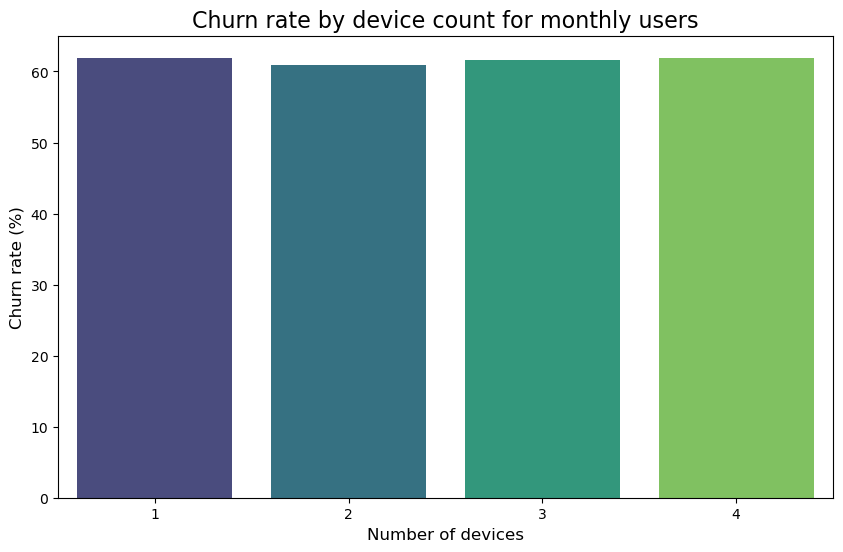

In [20]:
#using vpn on more devices does not lead to lower churn
churn_rate_by_devices = df_monthly.groupby('num_devices')['is_churned'].mean().reset_index()
churn_rate_by_devices['churn_rate_percentage'] = churn_rate_by_devices['is_churned'] * 100

print("Churn rate by device count for monthly users: ")
print(churn_rate_by_devices)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=churn_rate_by_devices, x='num_devices', y='churn_rate_percentage', palette='viridis')

ax.set_title('Churn rate by device count for monthly users', fontsize=16)
ax.set_xlabel('Number of devices', fontsize=12)
ax.set_ylabel('Churn rate (%)', fontsize=12)

plt.show()

churn rate for event driven signups
   is_event_month_signup  is_churned  churn_rate_percentage
0                      0    0.400910              40.090984
1                      1    0.395154              39.515355


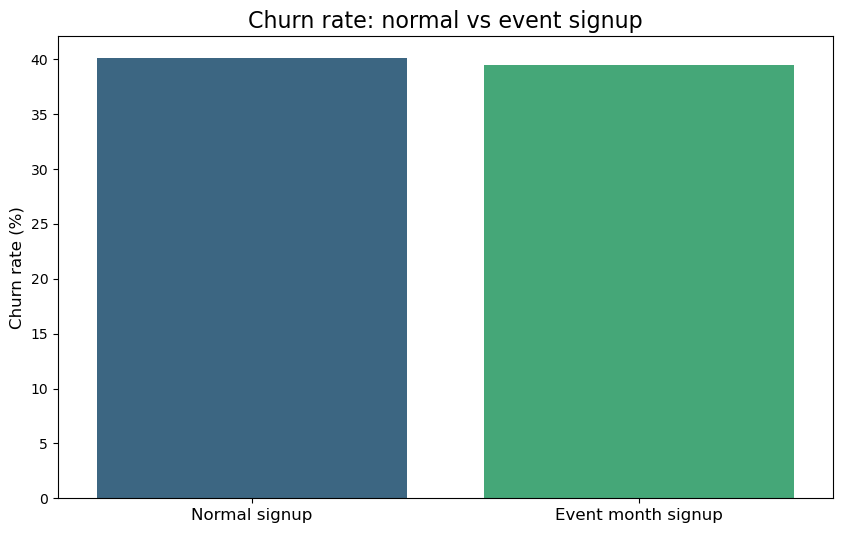

In [21]:
#normal signups have similar churn rate as event driven signups 
churn_by_event = df_merged_events.groupby('is_event_month_signup')['is_churned'].mean().reset_index()
churn_by_event['churn_rate_percentage'] = churn_by_event['is_churned']*100

print("churn rate for event driven signups")
print(churn_by_event)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=churn_by_event, x='is_event_month_signup', y='churn_rate_percentage', palette='viridis')
ax.set_title('Churn rate: normal vs event signup', fontsize=16)
ax.set_xticklabels(['Normal signup', 'Event month signup'], fontsize=12)
ax.set_xlabel('')
ax.set_ylabel('Churn rate (%)', fontsize=12)

plt.show()

<Figure size 1000x700 with 0 Axes>

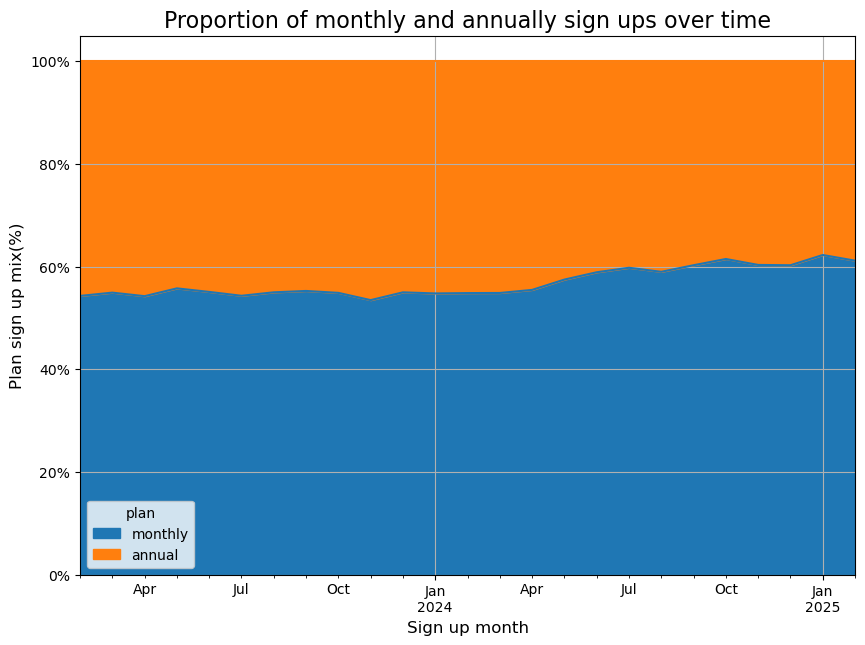

In [22]:
#checking if any specific plan had a spike in the dataset 
plan_mix_over_time = df_merged.groupby('signup_year_month')['plan'].value_counts(normalize=True).unstack()
plan_mix_over_time_pct = plan_mix_over_time*100

plt.figure(figsize=(10, 7))

if 'monthly' in plan_mix_over_time_pct.columns and 'annual' in plan_mix_over_time_pct.columns:
    ax = plan_mix_over_time_pct[['monthly', 'annual']].plot(kind='area', stacked=True,figsize=(10, 7))

    ax.set_title('Proportion of monthly and annually sign ups over time', fontsize=16)
    ax.set_xlabel('Sign up month', fontsize=12)
    ax.set_ylabel('Plan sign up mix(%)', fontsize=12)
    from matplotlib.ticker import PercentFormatter
    ax.yaxis.set_major_formatter(PercentFormatter())
    plt.grid(True)
    plt.show()
else: print('no column exists')